# **MODELING ONE STORM** #

#### Objectives: ####
+ Learn how STORM model storm as SHP-polygons and then transform them into RASTER
+ Recipes for spatial plotting via [Numpy](https://numpy.org/doc/stable/) (appealing color libraries included)

---

Two key concepts are worth considering here (and now):

1. STORM uses a bi-variate Gaussian copula to model the dependence between storm rainfall intensity and duration. A copula is a function that links/couples (thus its etymology) a multivariate (joint) distribution function to its univariate marginals, with no prior knowledge of the actual shape (or type) of such marginals (intensity and duration, in this case). 
2. STORM models individual storms as isotropic circular cells for which maximum intensities $(I_{max})$ are (always) located at their centres, with a quadratic exponential decay $(\beta^{2})$ as the distance from such centres $(r)$ increases:<a id='eq'></a>
    \begin{equation}
    I\big(r\big) = I_{max} \cdot e^{-2 \cdot \beta^{2} \cdot r^{2}},
    \tag{1}
    \end{equation}
    where $I\big(r\big)$ (in $\mathrm{mm \cdot h^{-1}}$) is the rainfall intensity at a distance $r$ (in $\mathrm{km}$) from the storm centre. $\beta$ has units of $\mathrm{km^{-1}}$.

<span style="color:HotPink">For a plethora of mathematical background on these and other components of STORM, you're encouraged to visit [this link](https://gmd.copernicus.org/preprints/gmd-2023-98/).</span>

---

Rainfall estimation and rasterization is done by STORM through the functions: COPULA_SAMPLING, LAST_RING, LOTR, and RASTERIZE of the [rainfall.py](../rainfall.py) module.

---

### STORM PARAMETERS ###
<a id='pars'></a>

In [1]:
# OGC-WKT for HAD [taken from https://epsg.io/42106]
WKT_OGC = (
    'PROJCS["WGS84_/_Lambert_Azim_Mozambique",'
    'GEOGCS["unknown",'
    'DATUM["unknown",'
    'SPHEROID["Normal Sphere (r=6370997)",6370997,0]],'
    'PRIMEM["Greenwich",0,'
    'AUTHORITY["EPSG","8901"]],'
    'UNIT["degree",0.0174532925199433,'
    'AUTHORITY["EPSG","9122"]]],'
    'PROJECTION["Lambert_Azimuthal_Equal_Area"],'
    'PARAMETER["latitude_of_center",5],'
    'PARAMETER["longitude_of_center",20],'
    'PARAMETER["false_easting",0],'
    'PARAMETER["false_northing",0],'
    'UNIT["metre",1,'
    'AUTHORITY["EPSG","9001"]],'
    'AXIS["Easting",EAST],'
    'AXIS["Northing",NORTH],'
    'AUTHORITY["EPSG","42106"]]'
)

# spatial resolution
# in meters! (pxl.resolution for the 'regular/local' CRS)
X_RES = 5000.0
# in meters! (pxl.resolution for the 'regular/local' CRS)
Y_RES = 5000.0
MINRADIUS = max([X_RES, Y_RES]) / 1e3
# in meters! -> buffer distance (out of the HAD)
BUFFER = 8000.0

# some SHP constraints
CLOSE_DIS = 0.15  # in km -> small circle emulating the storm centre's point/dot
# in km -> distance between (rainfall) rings; heavily dependant on X_Y_RES
RINGS_DIS = MINRADIUS * (2) + 0.1

## <u>RASTERIZING ONE STORM AT A TIME</u> ##

In [2]:
# first get rid of some (potential and) unwanted warnings
import warnings

# supressing warnings by "message"

# https://github.com/slundberg/shap/issues/2909
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
# https://stackoverflow.com/a/9134842/5885810
warnings.filterwarnings(
    "ignore",
    message="You will likely lose important projection "
    "information when converting to a PROJ string from another format",
)

In [3]:
# loading libraries
import cmaps  # -> nice color-palettes
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj as pp
import xarray as xr
from cmcrameri import cm as cmc
from matplotlib.patches import Circle
from numpy import random as npr
from osgeo import gdal
from pointpats import random as pran
from rasterio import fill
from scipy import stats
from statsmodels.distributions.copula.api import GaussianCopula

### 1. COMPUTE PDFs ###

One storm is constructed from 5 PDFs.\
<span style="color:RoyalBlue">(Check out notebook [one_](./one_.ipynb))</span>
<a id='pdfs'></a>

In [4]:
COPULA = {"": -0.31622, "Z1": -0.276457, "Z2": -0.312464, "Z3": -0.44}
MAXINT = {"": stats.expon(0.1057, 6.9955)}
AVGDUR = {"": stats.geninvgauss(-0.089, 0.77, 2.8432, 82.0786)}
RADIUS = {"": stats.johnsonsb(1.5187, 1.2696, -0.2789, 20.7977)}
BETPAR = {"": stats.exponnorm(8.2872, 0.0178, 0.01)}

First, we generate **n_s**-samples of intensity-duration in the [Copula](https://en.wikipedia.org/wiki/Copula_(probability_theory) domain.

In [5]:
n_s = 3
BAND = ""  # -> one of the key/tag/name's from the COPULA dictionary

# sampling from the copula
IntDur = GaussianCopula(corr=COPULA[BAND], k_dim=2).rvs(nobs=n_s).reshape(-1, 2)

# for reproducibility
IntDur = (
    GaussianCopula(corr=COPULA[BAND], k_dim=2)
    .rvs(nobs=n_s, random_state=npr.RandomState(npr.PCG64(5669876)))
    .reshape(-1, 2)
)
MAX_I = MAXINT[BAND].ppf(IntDur[:, 0])
DUR_S = AVGDUR[BAND].ppf(IntDur[:, 1])

# how does it look like?
print(IntDur)

[[0.61071263 0.87710212]
 [0.21967047 0.98564441]
 [0.75474953 0.37494087]]


Note that the retrieved samples range from 0 to 1; that's the copula's domain.
Now we need to transform those pairs from the copula's domain into the "intensity-duration" domain.
For that purpose, we use PDFs for storm intensity (i.e., **MAXINT**) and storm duration (i.e., **AVGDUR**).

In [6]:
MAX_I = MAXINT[BAND].ppf(IntDur[:, 0])
DUR_S = AVGDUR[BAND].ppf(IntDur[:, 1])

# how do they look like?
# storm intensity in mm/h
print(MAX_I)
# storm duration in minutes
print(DUR_S)

[6.70551677 1.84085664 9.93770232]
[239.73002819 558.8315374   57.29891514]


Then, **n_s**-samples of storm radius are generated, and truncated to the [MINRADIUS](#pars) limit, so there can't be storms smaller than the resolution of the model.

In [7]:
# set the limits
lim_ts = [1 * MINRADIUS, None]

# this transform the limits into the probability domain/space
LIMITS = [RADIUS[BAND].cdf(x) if x else None for x in lim_ts]

# if None in LIMITS
# https://stackoverflow.com/a/50049044/5885810 -> (None to NaN to Zero)
LIMITS = (
    np.nan_to_num(np.array(LIMITS, dtype="f8")) + np.r_[0, 1]
    if None in LIMITS
    else LIMITS
)

# for reproducibility
npr.seed(894765)
# sample the radii
RADII = RADIUS[BAND].ppf(npr.uniform(LIMITS[0], LIMITS[-1], size=n_s))

# how do they look like?
# storm radius in km
print(RADII)

[13.11900959  8.92419382  5.01969002]


<span style="color:HotPink">For this particular exercise, we increase the size of the radii, so the storms will be visible in such a vast area as it is the HAD.</span>
<a id='radii'></a>

In [8]:
RADII = RADII * 5.5

print(RADII)

[72.15455275 49.08306603 27.60829509]


Lastly, sampling of the exponential decay [**BETPAR**](#pdfs) (i.e. $\beta$ in [Equation (1)](#eq)).\
<span style="color:RoyalBlue">$\beta$-parameters close to zero (very small) imply "almost no-decrease" of the maximum storm intensity the further you move from the centre of the storm (as a function of $r$).</span>

In [9]:
# set the seed
npr.seed(233)
# sample the betas
BETAS = BETPAR[BAND].rvs(size=n_s)

# how do they look like?
print(BETAS)

[0.02841443 0.20982082 0.10673361]


### 2. DEFINE REGION ###

Read the shapefile acting as the catchment/region over/for which the storms will be generated/simulated.
Some buffer is also used here, to account also for some additional space in the underlying grid.

In [10]:
# read the SHP
wtrwgs = gpd.read_file("../model_input/HAD_basin.shp")
# re-project it to a local CRS
wtrshd = wtrwgs.to_crs(crs=WKT_OGC)  # //epsg.io/42106.wkt
# convert it into Pandas
CATCHM = gpd.GeoDataFrame(geometry=wtrshd.geometry)  # .to_crs(epsg=4326)
# the buffer
BUFFRX = gpd.GeoDataFrame(geometry=wtrshd.buffer(BUFFER))  # .to_crs(epsg=4326)

# how does the catchment look like?
print(CATCHM)

                                            geometry
0  POLYGON ((2543226.299 767453.737, 2545070.786 ...


Set up the (underlying) spatial grid (up to the desired buffer --with regard to the established resolution--).

In [11]:
# infering (and rounding) the limits of the buffer-zone
llim = np.floor(BUFFRX.bounds.minx[0] / X_RES) * X_RES  # +X_RES/2
rlim = np.ceil(BUFFRX.bounds.maxx[0] / X_RES) * X_RES  # -X_RES/2
blim = np.floor(BUFFRX.bounds.miny[0] / Y_RES) * Y_RES  # +Y_RES/2
tlim = np.ceil(BUFFRX.bounds.maxy[0] / Y_RES) * Y_RES  # -Y_RES/2

# DEFINE THE COORDINATES OF THE X-Y AXES
XS, YS = list(
    map(
        lambda a, b, c: np.arange(a + c / 2, b + c / 2, c),
        [llim, blim],
        [rlim, tlim],
        [X_RES, Y_RES],
    )
)

# flip YS
YS = np.flipud(YS)  # -> important...so rasters are compatible with numpys

# how do they look like?
print(XS[:7])
print(YS[-7:])

[1342500. 1347500. 1352500. 1357500. 1362500. 1367500. 1372500.]
[-1147500. -1152500. -1157500. -1162500. -1167500. -1172500. -1177500.]


### 3. SAMPLE STORM CENTRES ###

<span style="color:RoyalBlue">(Check out notebook [two_](./two_.ipynb))</span>

In [12]:
# set the seed (for this notebook's sake)
npr.seed(546846)
CENTS = pran.poisson(CATCHM.geometry.xs(0), size=n_s)

# what do they look like?
print(CENTS)

[[2505448.49327476  841520.4188831 ]
 [2278457.56241648  703196.79461003]
 [2082039.98979901 -825624.9487317 ]]


### 4. COMPUTE $I(r)$ ###

Let's compute rainfall intensities for several distances beyond the storm center.
The regular spacing between such distances was previously set up in the [**RINGS_DIS**](#pars) variable.

In [13]:
# distances separation (in km)
print(RINGS_DIS)

10.1


For every sampled center, several distances (spaced every **RINGS_DIS**-km) are estimated between storm center and storm radius.\
<span style="color:RoyalBlue">Note that the distances increase from *almost* the storm center to storm (maximum) radius (see variable [**RADII**](#radii) above).</span>

In [14]:
all_radii = list(
    map(lambda r: np.r_[np.arange(r, CLOSE_DIS, -RINGS_DIS), CLOSE_DIS], RADII)
)

# what do those distances look like?
all_radii

[array([72.15455275, 62.05455275, 51.95455275, 41.85455275, 31.75455275,
        21.65455275, 11.55455275,  1.45455275,  0.15      ]),
 array([49.08306603, 38.98306603, 28.88306603, 18.78306603,  8.68306603,
         0.15      ]),
 array([27.60829509, 17.50829509,  7.40829509,  0.15      ])]

Then, rain is computed using (via FORMUKA 1) for the previous several distances.\
<span style="color:RoyalBlue">Note now that rainfall intensity decreases from *almost* the storm center to storm (maximum) radius (consistent with what [Equation (1)](#eq) proposes).</span>

In [15]:
all_rain = list(
    map(
        lambda i, d, b, r: list(
            map(
                lambda r:
                # # model: FORCE_BRUTE -> a * np.exp(-2 * b * x**2)
                # i * d * 1 / 60 * np.exp(-2 * b * r**2),
                # model: BRUTE_FORCE -> a * np.exp(-2 * b**2 * x**2)
                i * d * 1 / 60 * np.exp(-2 * b**2 * r**2),
                r,
            )
        ),
        MAX_I,
        DUR_S,
        BETAS,
        all_radii,
    )
)

# what does rainfall intensity look like?
all_rain

[[0.005983238754889605,
  0.053398824773079785,
  0.34280853641774955,
  1.5830554240756662,
  5.2585399246679545,
  12.564892990989849,
  21.59618187118039,
  26.7005201184977,
  26.790922020930523],
 [1.2874081948229739e-91,
  1.3257668677168718e-57,
  2.1558006804063954e-31,
  5.53529280643682e-13,
  0.022442082000436195,
  17.111545600057266],
 [2.72344971628483e-07,
  0.008791395955391681,
  2.7177805325374034,
  9.485462130217563]]

### 5. RINGS OF RAINFALL ###

Knowing how rainfall (intensity) behaves the further it is from the storm center, circular polygons can now be created.
The idea is to later rasterize such polygons.

In [16]:
# BUFFER_STRINGS
# https://www.knowledgehut.com/blog/programming/python-map-list-comprehension
# https://stackoverflow.com/a/30061049/5885810  (map nest)
# r,p are lists (at first instance), and the numbers/atoms (in the second lambda)
# .boundary gives the LINESTRING element
# *1e3 to go from km to m
# np.ceil(r /MINRADIUS) +2 ) is an artifact to lower the resolution of small circles
# ...a lower resolution in such circles increases the script.speed in the rasterisation process.
RINGS = list(
    map(
        lambda c, r, p: pd.concat(
            list(
                map(
                    lambda r, p: gpd.GeoDataFrame(
                        {
                            "rain": p,
                            "geometry": gpd.points_from_xy(x=[c[0]], y=[c[1]])
                            # or maybe... "+1"??
                            .buffer(
                                r * 1e3, resolution=np.ceil(r / MINRADIUS) + 2
                            ).boundary,
                        },
                        crs=WKT_OGC,
                    ),
                    r,
                    p,
                )
            )
        ),
        CENTS,
        all_radii,
        all_rain,
    )
)

# what does a ring of rainfall look like?
RINGS

[        rain                                           geometry
 0   0.005983  LINESTRING (2577603.046 841520.419, 2577295.24...
 0   0.053399  LINESTRING (2567503.046 841520.419, 2567163.10...
 0   0.342809  LINESTRING (2557403.046 841520.419, 2557024.23...
 0   1.583055  LINESTRING (2547303.046 841520.419, 2546877.02...
 0   5.258540  LINESTRING (2537203.046 841520.419, 2536720.62...
 0  12.564893  LINESTRING (2527103.046 841520.419, 2526560.12...
 0  21.596182  LINESTRING (2517003.046 841520.419, 2516437.52...
 0  26.700520  LINESTRING (2506903.046 841520.419, 2506708.17...
 0  26.790922  LINESTRING (2505598.493 841520.419, 2505578.39...,
            rain                                           geometry
 0  1.287408e-91  LINESTRING (2327540.628 703196.795, 2327120.71...
 0  1.325767e-57  LINESTRING (2317440.628 703196.795, 2316960.68...
 0  2.155801e-31  LINESTRING (2307340.628 703196.795, 2306785.64...
 0  5.535293e-13  LINESTRING (2297240.628 703196.795, 2296600.61...
 0  2.244

### 6. ONE STORM RASTERIZATION ###

We rasterize all storms, but we visualize only one case.
<a id='fall'></a>

In [17]:
# where the rasters are gonna be stored
fall = []

for ALL_RINGS in RINGS:
    # burn the ALL_RINGS inside a storm
    tmp = gdal.Rasterize(
        "",
        ALL_RINGS.to_json(),
        xRes=X_RES,
        yRes=Y_RES,
        allTouched=True,
        attribute="rain",
        noData=0,
        outputType=gdal.GDT_Float64,
        targetAlignedPixels=True,
        outputBounds=[llim, blim, rlim, tlim],
        outputSRS=pp.CRS.from_wkt(WKT_OGC).to_proj4(),
        format="MEM",
        # width=int(abs(rlim - llim) / X_RES),
        # height=int(abs(tlim - blim) / X_RES),
    )
    fall.append(tmp.ReadAsArray())
    tmp = None

C:\Users\manuel\AppData\Local\Temp\ipykernel_41720\590111119.py:8: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  ALL_RINGS.to_json(),
C:\Users\manuel\AppData\Local\Temp\ipykernel_41720\590111119.py:8: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  ALL_RINGS.to_json(),
C:\Users\manuel\AppData\Local\Temp\ipykernel_41720\590111119.py:8: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  ALL_RINGS.to_json(),


<span style="color:MediumSeaGreen">*Change some output parameters from Numpy.*</span>

In [18]:
np.set_printoptions(suppress=True)
np.set_printoptions(edgeitems=20, linewidth=2000)

Now let's check if those rainfall rings where rasterized OK.

In [19]:
posx = 0  # 0, 1 or 2 -> because we're only having n_s==3

print(fall[posx][50:64, 217:235].round(3))

[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.006  0.006  0.006  0.006  0.006  0.006  0.006]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.006  0.006  0.006  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.006  0.006  0.006  0.     0.053  0.053  0.053  0.053  0.053  0.053  0.053]
 [ 0.     0.     0.     0.     0.     0.     0.006  0.006  0.     0.053  0.053  0.053  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.006  0.006  0.     0.053  0.053  0.     0.     0.343  0.343  0.343  0.343  0.343  0.343]
 [ 0.     0.     0.     0.     0.006  0.006  0.     0.053  0.053  0.     0.343  0.343  0.343  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.006  0.006  0.     0.053  0.053  0.     0.343  0.343  0.     1.583  1.5

It looks quite OK and slick, right?.
You might be wondering now what are those zeroes inside the storm.
To speed things up, rings of rainfall are generated not that close, and the gaps in between are later filled by interpolation.

<span style="color:MediumSeaGreen">*Restore Numpy's output parameters back!.*</span>

In [20]:
# restore defaults?
# https://ahaldane.github.io/reference/generated/numpy.set_printoptions.html
np.set_printoptions(edgeitems=3, linewidth=75)

What if instead of rainfall rings all i want is the mask of the storm (or any other shape for that matter)?.

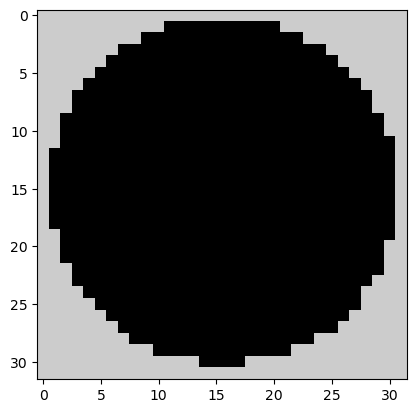

In [21]:
# where the rasters are gonna be stored
mask = []

for ALL_RINGS in RINGS:
    # burn the mask
    # convert LINESTRING to POLYGON (in shapely). ".iloc[0]" for the largest/outter RADII
    # https://stackoverflow.com/a/2975194/5885810
    OUTER_RING = (ALL_RINGS.geometry.iloc[0]).convex_hull

    # create a GEOPANDAS from a SHAPELY so you can JSON.it
    # https://stackoverflow.com/a/51520122/5885810
    tmp = gdal.Rasterize(
        "",
        gpd.GeoSeries([OUTER_RING]).to_json(),
        xRes=X_RES,
        yRes=Y_RES,
        allTouched=True,
        burnValues=1,
        noData=0,
        outputType=gdal.GDT_Int16,
        targetAlignedPixels=True,
        outputBounds=[llim, blim, rlim, tlim],
        outputSRS=pp.CRS.from_wkt(WKT_OGC).to_proj4(),
        format="MEM",
    )
    mask.append(tmp.ReadAsArray())
    tmp = None

plt.imshow(
    mask[posx][50:82, 217:249],
    origin="upper",
    vmin=0.0,
    # cmap="MPL_Dark2_r",
    cmap="nipy_spectral_r",
    # interpolation='nearest',
)

---

### *INTERMEZZO: EXPORT CATCHMENT AS NUMPY* ###
<span style="color:MediumSeaGreen">*(while we're at it... it will be used later in notebook [for_](./for_.ipynb))*</span>
<a id='mask'></a>

In [22]:
# read the shape
# catchment shape-file in WGS84
SHP_FILE = "../model_input/HAD_basin.shp"
wtrwgs = gpd.read_file(SHP_FILE)

# re-project it
wtrshd = wtrwgs.to_crs(crs=WKT_OGC)  # //epsg.io/42106.wkt

# rasterize it
tmp = gdal.Rasterize(
    "",
    wtrshd.to_json(),
    format="MEM",
    add=0,
    xRes=X_RES,
    yRes=Y_RES,
    noData=0,
    burnValues=1,
    allTouched=True,
    outputType=gdal.GDT_Int16,
    outputBounds=[llim, blim, rlim, tlim],
    # targetAlignedPixels=False, # (check: https://gdal.org/programs/gdal_rasterize.html#cmdoption-gdal_rasterize-tap)
    targetAlignedPixels=True,
    outputSRS=pp.CRS.from_wkt(WKT_OGC).to_proj4(),
    # width=(abs(rlim - llim) / X_RES).astype("u2"),
    # height=(abs(tlim - blim) / X_RES).astype("u2"),
)
CATCHMENT_MASK = tmp.ReadAsArray().astype("u1")
# flush it
tmp = None

# the xporting happens here
np.save(
    "tre_catchment-mask",
    CATCHMENT_MASK.astype("u1"),
    allow_pickle=True,
    fix_imports=True,
)

C:\Users\manuel\AppData\Local\Temp\ipykernel_41720\3398665059.py:12: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  wtrshd.to_json(),


---

### VISUALIZATION ###

Check this awesome [link](https://github.com/hhuangwx/cmaps/blob/master/examples/colormaps.png)... and then load some cool color palettes.

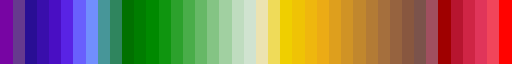

In [23]:
cmaps.Carbone42

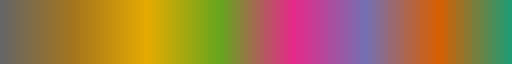

In [24]:
# and/or
cmaps.MPL_Dark2_r

Now, let's put some color to that [**fall**](#fall) Numpy, i.e., let's see how those rings of rainfall look like. 

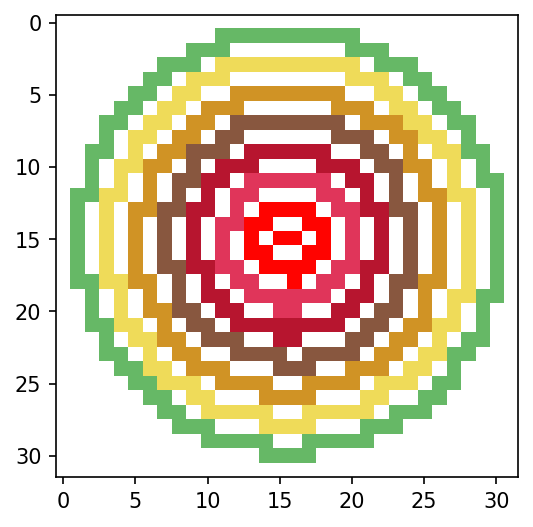

In [25]:
plt.figure(figsize=(4, 4), dpi=150)
# plt.imshow(fall[50:82,217:249], origin='upper', norm='log', vmin=0.005, cmap='MPL_Dark2_r', interpolation=None)
plt.imshow(
    fall[posx][50:82, 217:249],
    origin="upper",
    norm="log",
    vmin=0.00003,
    # cmap="MPL_Dark2_r",
    cmap="Carbone42",
    interpolation="none",
)

The voids/zeros in [**fall**](#fall) (within the extension of the storm) are the pixels which need now to be filled in.
Let's see how (or where) those pixels look like.

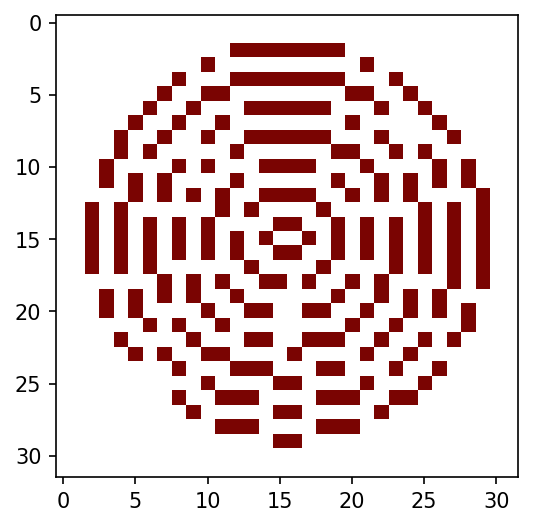

In [26]:
# re-touching the mask...to do a proper interpolation
mask[posx][np.where(fall[posx] != 0)] = 0

# plot the voids (inside the storm
plt.figure(figsize=(4, 4), dpi=150)
plt.imshow(
    mask[posx][50:82, 217:249],
    origin="upper",
    norm="log",
    vmin=0.005,
    cmap="turbo",
    interpolation="none",
)

Finally, here is where the interpolation happens.

In [27]:
for i in range(len(fall)):
    # note that this is done "in real time"
    fill.fillnodata(
        np.ma.array(fall[i], mask=mask[i]),
        mask=None,
        max_search_distance=4.0,
        smoothing_iterations=2,
    )

# how does the filling look like?
fall

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

### VISUALIZATION (VIA XARRAY) ###

<span style="color:RoyalBlue">*STORM always computes the storm for the whole region/catchment of analyis.
What we've done here is to cherry-pick the area where the storm was being modeled.*</span>
<a id='da'></a>

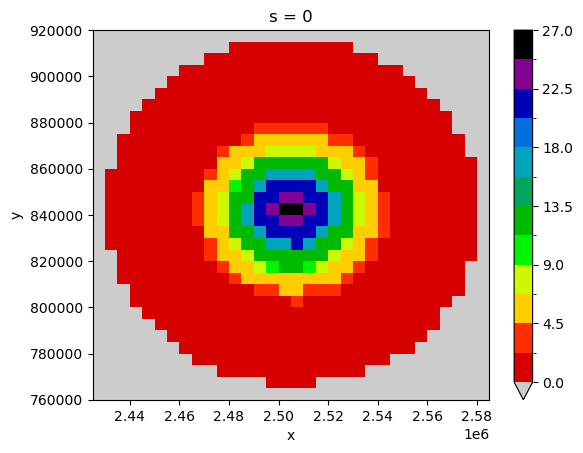

In [28]:
# convert "fall" into a xarray
da = xr.DataArray(
    data=fall,
    dims=["s", "y", "x"],
    coords={"s": np.r_[0:n_s], "x": XS, "y": YS},
)
# pa = xr.DataArray(data=mask, dims=['t','y','x'], coords={'t':np.r_[0:n_s], 'x':XS, 'y':YS},)

# find first the "right" slices
da.isel(
    {
        "s": posx,
        "x": slice(217, 249),
        "y": slice(50, 82),
    }
).plot(cmap="nipy_spectral_r", levels=13, vmin=0.005, vmax=27)

Import a much nicer color palette, and apply it to the xarray (overlay the rainfall rings, why not).

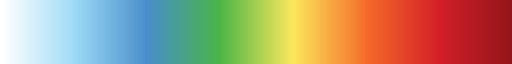

In [29]:
cmaps.WhiteBlueGreenYellowRed

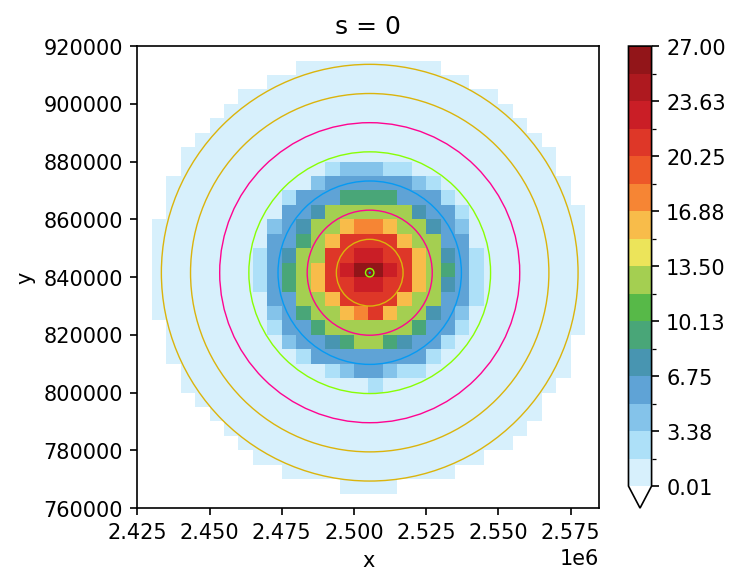

In [30]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.set_aspect("equal")

# find the right slices
da.isel(
    {
        "s": posx,
        "x": slice(217, 249),
        "y": slice(50, 82),
    }
).plot(cmap="WhiteBlueGreenYellowRed", levels=17, vmin=0.005, vmax=27, ax=ax)

# plotting of rings happens here
for rr in all_radii[posx] * 1e3:
    circ = Circle(
        (CENTS[posx][0], CENTS[posx][1]),
        rr,
        alpha=1,
        facecolor="None",
        lw=0.67,
        edgecolor=npr.choice(
            ["xkcd:lime green", "xkcd:gold", "xkcd:electric pink", "xkcd:azure"]
        ),
    )
    ax.add_patch(circ)

# # https://stackoverflow.com/a/64035939/5885810  (add vertical lines)
# plt.vlines(
#     x=np.arange(1920000, 1990000, 5000),
#     ymin=-180000,
#     ymax=-100000,
#     colors="xkcd:off white",
#     ls="dotted",
#     lw=0.09,
# )
# plt.hlines(
#     y=np.arange(-110000, -180000, -5000),
#     xmin=1910000,
#     xmax=1990000,
#     colors="xkcd:off white",
#     ls="dotted",
#     lw=0.09,
# )

plt.show()

# # use these for exporting and cleaning [don't forget to comment out "plt.show()"!!]
# plt.savefig(
#     "tre_.pdf", bbox_inches="tight", pad_inches=0.02, facecolor=fig.get_facecolor()
# )
# plt.close()
# plt.clf()

Print the storm instensities and radii again, so you can check their values against the last plot (above).

In [31]:
print(all_radii[0])
print(RINGS[0])

[72.15455275 62.05455275 51.95455275 41.85455275 31.75455275 21.65455275
 11.55455275  1.45455275  0.15      ]
        rain                                           geometry
0   0.005983  LINESTRING (2577603.046 841520.419, 2577295.24...
0   0.053399  LINESTRING (2567503.046 841520.419, 2567163.10...
0   0.342809  LINESTRING (2557403.046 841520.419, 2557024.23...
0   1.583055  LINESTRING (2547303.046 841520.419, 2546877.02...
0   5.258540  LINESTRING (2537203.046 841520.419, 2536720.62...
0  12.564893  LINESTRING (2527103.046 841520.419, 2526560.12...
0  21.596182  LINESTRING (2517003.046 841520.419, 2516437.52...
0  26.700520  LINESTRING (2506903.046 841520.419, 2506708.17...
0  26.790922  LINESTRING (2505598.493 841520.419, 2505578.39...


<span style="color:RoyalBlue">Alternative plot-tweaking.</span>

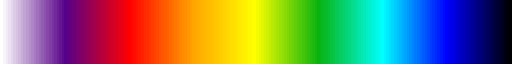

In [32]:
cmaps.BkBlAqGrYeOrReViWh200_r

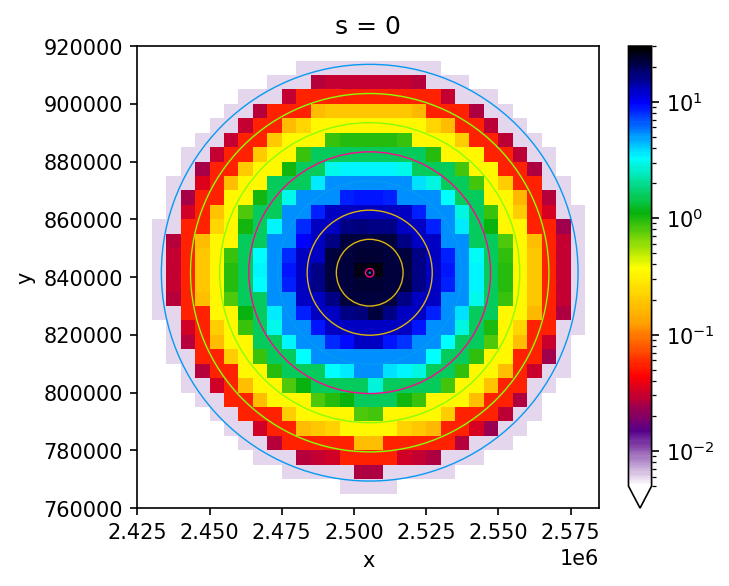

In [33]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.set_aspect("equal")

# log.scale (find the right slices)
da.isel(
    {
        "s": posx,
        "x": slice(217, 249),
        "y": slice(50, 82),
    }
).plot(
    cmap="BkBlAqGrYeOrReViWh200_r",
    levels=230,
    vmin=0.005,
    vmax=30,
    ax=ax,
    norm=colors.LogNorm(vmin=0.005, vmax=30),
)

# plotting of rings happens here
for rr in all_radii[posx] * 1e3:
    circ = Circle(
        (CENTS[posx][0], CENTS[posx][1]),
        rr,
        alpha=1,
        facecolor="None",
        lw=0.67,
        edgecolor=npr.choice(
            ["xkcd:lime green", "xkcd:gold", "xkcd:electric pink", "xkcd:azure"]
        ),
    )
    ax.add_patch(circ)

plt.show()

#### ALL STORMS AT ONCE ####

Now let's do a proper visulization with the storm into the (spatial) context of the HAD.
We've read before the HAD-mask, so we can now plot it here.
But first, let's collapse the already rasterized (and filled/interpolated) [**da**](#da) xarray into the **s**-dimension (z-axis).

In [34]:
# the "sum" of all storms
alls = da.sum(dim="s")

# what does it look like?
alls

<xarray.DataArray (y: 470, x: 408)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 1.342e+06 1.348e+06 1.352e+06 ... 3.372e+06 3.378e+06
  * y        (y) float64 1.168e+06 1.162e+06 1.158e+06 ... -1.172e+06 -1.178e+06

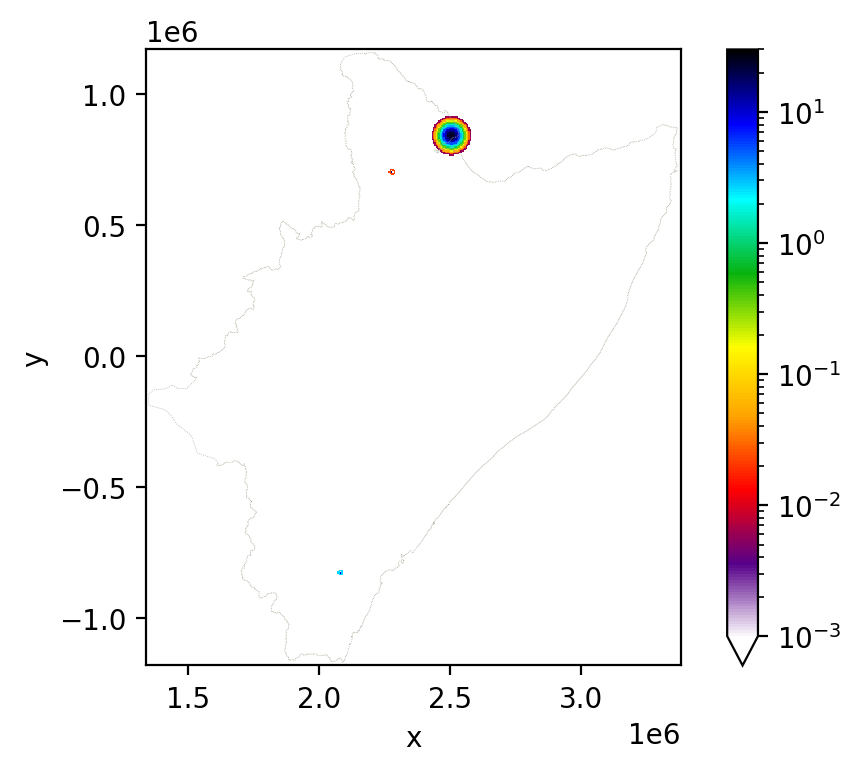

In [35]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
ax.set_aspect("equal")

# how does my entire array look like?
alls.plot(
    cmap="BkBlAqGrYeOrReViWh200_r",
    levels=199,
    vmin=0.001,
    vmax=30,
    ax=ax,
    norm=colors.LogNorm(vmin=0.001, vmax=30),
)
wtrshd.boundary.plot(ax=ax, color="xkcd:cement", lw=0.27, ls="dotted")

plt.show()

<span style="color:MediumSeaGreen">Unfortunately there are small storms difficult to observe here (even with the logarithmic color map)... hence, you're highly encouraged to compute many more and much bigger!!</span>